In [1]:
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

# Base Folder 및 PDF 경로 설정
base_folder = "/content/drive/MyDrive/AiffelThon/csy/Langgraph_tutorial"
pdf_folder = "/content/drive/MyDrive/AiffelThon/Input_data"

Mounted at /content/drive


In [2]:
!pip install langgraph langchain langchain_openai pypdf2 sentence-transformers faiss-gpu faiss-cpu langchain-community langchain_teddynote python-dotenv

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.7/34.7 MB 54.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.1 MB/s eta 0:00:00
   ━━━━

In [3]:
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 20.9 MB/s eta 0:00:00


In [4]:
import os
import getpass
from dotenv import load_dotenv

## retriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores.base import VectorStoreRetriever

## tool
from langgraph.prebuilt import ToolExecutor
from langchain.tools.retriever import create_retriever_tool

## agent
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

## Nodes and Edges
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.messages import BaseMessage, FunctionMessage, HumanMessage
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolInvocation
from langchain_core.output_parsers import StrOutputParser

## Graph
from langgraph.graph import END, StateGraph

## Response
import pprint
from langchain_core.messages import HumanMessage

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
from dotenv import load_dotenv
import os

dotenv_path = os.path.join(base_folder, ".env")

# .env 파일 로드
load_dotenv(dotenv_path=dotenv_path)

# API 키 가져오기
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

# LangSmith 추적 기능을 활성화합니다. (선택적)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

### PDF 파일을 경로로 불러들임

In [6]:
input_pdfs = []  # PDF 경로를 저장할 리스트

for i in range(1, 144):
    input_pdf = os.path.join(pdf_folder, f"paper_{str(i).zfill(3)}.pdf")
    input_pdfs.append(input_pdf)

# 출력 (테스트용)
for pdf in input_pdfs:
    print(pdf)

/content/drive/MyDrive/AiffelThon/Input_data/paper_001.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_002.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_003.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_004.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_005.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_006.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_007.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_008.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_009.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_010.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_011.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_012.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_013.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_014.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_015.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_016.pdf
/content/drive/MyDrive/AiffelThon/Input_data/paper_017.p

In [7]:
def embedding_file(file: str) -> VectorStoreRetriever:
    """문서를 청크 단위로 분할하고 임베딩 모델(text-embedding-ada-002)을 통해 임베딩하여 vector store에 저장합니다. 이후 vector store를 기반으로 검색하는 객체를 생성합니다.

    Args:
        file (str): pdf 문서 경로

    Returns:
        VectorStoreRetriever: 검색기
    """

    ## 긴 텍스트를 작은 청크로 나누는 데 사용되는 클래스
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500,         ## 최대 청크 길이 정의
        chunk_overlap=100,      ## 청크 간 겹침 길이 정의
        separators=["\n\n"]     ## 텍스트를 나눌 때 사용할 구분자를 지정 (문단)
    )

    ## PDF 파일 불러오기
    loader = PyPDFLoader(f"{file}")
    docs = loader.load_and_split(text_splitter=splitter)

    ## Embedding 생성 및 vector store에 저장
    embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(
        documents=docs,         ## 벡터 저장소에 추가할 문서 리스트
        embedding=embeddings    ## 사용할 임베딩 함수
    )

    ## 검색기로 변환: 현재 벡터 저장소를 기반으로 VectorStoreRetriever 객체를 생성하는 기능을 제공
    retriever = vector_store.as_retriever(
        search_type="similarity"    ## 어떻게 검색할 것인지? default가 유사도
    )

    return retriever

## 아래의 input_pdfs[i]를 조절해서 input을 대량으로 끌고오는 걸 고려해봐야함

In [8]:
retriever = embedding_file(file=input_pdfs[138])

In [9]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

In [10]:
from langchain_teddynote.messages import messages_to_history
from langchain_core.documents.base import Document
from langchain_teddynote.evaluator import GroundednessChecker

def format_docs(docs: list[Document]) -> str:
    """문시 리스트에서 텍스트를 추출하여 하나의 문자로 합치는 기능을 합니다.

    Args:
        docs (list[Document]): 여러 개의 Documnet 객체로 이루어진 리스트

    Returns:
        str: 모든 문서의 텍스트가 하나로 합쳐진 문자열을 반환
    """
    return "\n\n".join(doc.page_content for doc in docs)

# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # prompt 설정
    prompt = PromptTemplate(
        template="""
        Based on the following document, please provide an answer to the given question.

        Document:
        {context}

        Question:
        {question}

        Answer:
        """,
        input_variables=["context", "question"],
        )

    # llm 호출
    llm = ChatOpenAI(
        model_name="gpt-4o",
        temperature=0.7,
        streaming=True
        )

    # 체인 호출
    chain = prompt | llm | StrOutputParser()

    response = chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response,
        messages=[("user", latest_question), ("assistant", response)]
    )


# 관련성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 평가기를 생성합니다.
    retrieval_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o", temperature=0.7), target="retrieval-answer"
    ).create()

    # 관련성 체크를 실행("yes" or "no")
    response = retrieval_answer_relevant.invoke(
        {"context": state["context"], "answer": state["answer"]}
    )

    print("==== [RELEVANCE CHECK] ====")
    print(response.score)

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
    return GraphState(relevance=response.score)


# 관련성 체크하는 함수(router)
def is_relevant(state: GraphState) -> GraphState:
    return state["relevance"]

In [11]:
# from langgraph.graph import END, StateGraph
# from langgraph.checkpoint.memory import MemorySaver

# # 그래프 생성
# workflow = StateGraph(GraphState)

# # 노드 정의
# workflow.add_node("retrieve", retrieve_document)
# workflow.add_node("relevance_check", relevance_check)
# workflow.add_node("llm_answer", llm_answer)

# # 엣지 정의
# workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크

# # 조건부 엣지를 추가합니다.
# workflow.add_conditional_edges(
#     "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
#     is_relevant,
#     {
#         "yes": "llm_answer",  # 관련성이 있으면 답변을 생성합니다.
#         "no": "retrieve",  # 관련성이 없으면 다시 검색합니다.
#     },
# )

# # 그래프 진입점 설정
# workflow.set_entry_point("retrieve")

# # 체크포인터 설정
# memory = MemorySaver()

# # 컴파일
# app = workflow.compile(checkpointer=memory)

In [12]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # _start_ -> 검색 시작
workflow.add_edge("llm_answer", "relevance_check")  # 답변 생성 -> 관련성 체크

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "yes": END,  # 관련성이 있으면 _end_로 이동합니다.
        "no": "retrieve",  # 관련성이 없으면 다시 검색합니다.
    },
)


# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

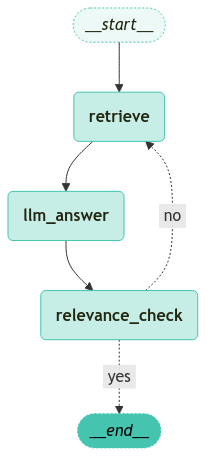

In [13]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [14]:
# from langchain_core.runnables import RunnableConfig
# from langchain_teddynote.messages import stream_graph, random_uuid, invoke_graph

# # config 설정(재귀 최대 횟수, thread_id)
# config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# # 질문 입력
# inputs = GraphState(question="""Below are instructions for filling out items by referring to the examples.
# The values shown to the right of the colon (“:”) are examples;
# please delete them after reviewing and rewrite them with the values found in the PDF.
# If any item is not mentioned in the PDF, do not remove it—write “None.”

# 2.1 Cathode Active material, Conductive additive, Binder ratio: 90, 5, 5
# 2.2 Electrolyte: LiPF6 (EC, EMC, DEC mixture in a 1:1:1 volume ratio)
# 2.3 Additive: FEC 10% addition
# 2.4 Electrode thickness: 100 µm
# 2.5 only Cathode Electrode diameter: 14π
# 2.6 Cathode Electrode area: 1.5 cm^2
# 2.7 Loading density (mass loading of NCM): 0.005 g/cm^2
# 2.8 additional treatment for electrode: None""")

In [15]:
# # 그래프 실행
# stream_graph(
#     graph=app,
#     inputs=inputs,
#     config=config,
#     node_names=["relevance_check", "llm_answer"]
# )
# outputs = app.get_state(config).values

In [16]:
# import os
# import json

# # 'outputs'에서 'answer' 값 추출
# answer_value = outputs['answer']

# # 저장할 폴더와 파일 이름 지정
# save_folder = "/content/drive/MyDrive/AiffelThon/csy/Langgraph_tutorial/json"  # 원하는 경로로 변경
# file_name = "answer_value_2.json"

# # 경로를 합쳐 JSON 파일 전체 경로 생성
# save_path = os.path.join(save_folder, file_name)

# # JSON 파일로 저장
# with open(save_path, 'w', encoding='utf-8') as json_file:
#     json.dump({"answer": answer_value}, json_file, ensure_ascii=False, indent=4)

# print(f"answer_value가 JSON 파일로 저장되었습니다: {save_path}")


In [17]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 4개의 질문 입력
questions = [
    """Below are instructions for filling out items by referring to the examples.
    The values shown to the right of the colon (“:”) are examples;
    please delete them after reviewing and rewrite them with the values found in the PDF.
    If any item is not mentioned in the PDF, do not remove it—write “None.”

    1. CAM (Cathode Active Material)
    1.1 Stoichiometry information: NCM-622
    1.2 Commercial NCM (check if specified in the paper): No
    1.3 Lithium source: LiOH
    1.4 Synthesis method (co-precipitation or Sol-gel method): co-precipitation
    1.5 Crystallization method (Hydrothermal or Sintering): Hydrothermal
    1.6 Crystallization temperature: 100°C
    1.7 Crystallization time: 12 hr
    1.8 Doping: Zr4+ doping
    1.9 Coating: ZrO2 coating
    1.10 additional treatment: None""",

    """Below are instructions for filling out items by referring to the examples.
    The values shown to the right of the colon (“:”) are examples;
    please delete them after reviewing and rewrite them with the values found in the PDF.
    If any item is not mentioned in the PDF, do not remove it—write “None.”

    2.1 Active material, Conductive additive, Binder ratio: 90, 5, 5
    2.2 Electrolyte: LiPF6 (EC, EMC, DEC mixture in a 1:1:1 volume ratio)
    2.3 Additive: FEC 10% addition
    2.4 Electrode thickness: 100 µm
    2.5 only Cathode Electrode diameter: 14π
    2.6 Cathode Electrode area: 1.5 cm^2
    2.7 Loading ammount (mass loading of CAM): 25 mg
    2.8 Loading density: 9.1 mg/cm^2""",

    """Below are instructions for filling out items by referring to the examples.
    The values shown to the right of the colon (“:”) are examples;
    please delete them after reviewing and rewrite them with the values found in the PDF.
    If any item is not mentioned in the PDF, do not remove it—write “None.”

    3. Morphological results
    3.1 Explanation of SEM results (indicate figure numbers as well):
    ex) Fig. 2a, b;the NCM-622 seems to have a spherical morphology with a diameter of 3–5 µm, composed of densely packed primary particles
    3.2 Explanation of TEM results: None""",

    """Below are instructions for filling out items by referring to the examples.
    The values shown to the right of the colon (“:”) are examples;
    please delete them after reviewing and rewrite them with the values found in the PDF.
    If any item is not mentioned in the PDF, do not remove it—write “None.”

    4. Cathode Performance
    4.1 Capacity at all C-rate, mAh/g (with electrode state; e.g., coated or uncoated): {"214.5 mAh/g":"@0.1C, ZrO2-coated", "200.8 mAh/g":"@0.5C, ZrO2-coated"}
    4.2 Voltage range: 2.8–4.3 V
    4.3 Temperature: Room temperature and 55°C"""
]

# 4개의 질문에 대해 그래프 실행 및 출력
outputs = []
for i, question in enumerate(questions):
    inputs = GraphState(question=question)
    stream_graph(
        graph=app,
        inputs=inputs,
        config=config,
        node_names=["relevance_check", "llm_answer"]
    )
    output = app.get_state(config).values
    outputs.append(output)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
1. CAM (Cathode Active Material)
1.1 Stoichiometry information: Li[Ni0.73Co0.12Mn0.15]O2
1.2 Commercial NCM (check if specified in the paper): No
1.3 Lithium source: LiOH
1.4 Synthesis method (co-precipitation or Sol-gel method): co-precipitation
1.5 Crystallization method (Hydrothermal or Sintering): Sintering
1.6 Crystallization temperature: 750°C
1.7 Crystallization time: 20 hr
1.8 Doping: None
1.9 Coating: Al2O3 coating
1.10 additional treatment: None
🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [RELEVANCE CHECK] ====
yes

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2.1 Active material, Conductive additive, Binder ratio: 80, 10, 10  
2.2 Electrolyte: LiPF6 (EC, DEC, DMC mixture in a 1:1:1 volume ratio)  
2.3 Additive: None  
2.4 Electrode thickness: None  
2.5 only Cathode Electrode diameter: None  
2.6 Cathode Electrode area: 1.5 cm^2  
2.7 Load